In [1]:
%%writefile cookbook.py

from dataclasses import dataclass
from typing import Dict, List


@dataclass(frozen=True)
class Ingredient:
    name: str
    cost: int
    base_value: float
    rarity_multiplier: float = 1.0


INGREDIENTS: List[Ingredient] = [
    Ingredient("Tomato", 2, 0.8),
    Ingredient("Onion", 1, 0.9),
    Ingredient("Garlic", 3, 0.7),
    Ingredient("Basil", 4, 0.5),
    Ingredient("Cheese", 5, 0.4),
    Ingredient("Meat", 8, 0.3),
    Ingredient("Truffle", 15, 0.1),
    Ingredient("Salt", 1, 1.0),
    Ingredient("Pepper", 2, 0.8),
    Ingredient("Olive Oil", 3, 0.6),
    Ingredient("Mushroom", 4, 0.45, 1.2),
    Ingredient("Lemon", 2, 0.65, 0.4),
    Ingredient("Parsley", 1, 0.7, 0.2),
    Ingredient("Shrimp", 7, 0.25, 3.0),
    Ingredient("Wine", 6, 0.2, 2.0),
    Ingredient("Pasta", 6, 0.2, 1.0),
]

NAME_TO_INDEX: Dict[str, int] = {ing.name: i for i, ing in enumerate(INGREDIENTS)}

RECIPES: Dict[frozenset, Dict[str, float]] = {
    frozenset(["Tomato", "Basil", "Cheese"]): {"name": "Margherita", "multiplier": 2.0},
    frozenset(["Meat", "Onion", "Garlic"]): {"name": "Steak", "multiplier": 1.8},
    frozenset(["Truffle", "Cheese", "Olive Oil", "Pasta"]): {"name": "Truffle Pasta", "multiplier": 3.0},
    frozenset(["Tomato", "Onion", "Garlic", "Basil"]): {"name": "Marinara", "multiplier": 1.5},
    frozenset(["Salt", "Pepper"]): {"name": "Basic Seasoning", "multiplier": 0.8},
    frozenset(["Mushroom", "Garlic", "Parsley"]): {"name": "Mushroom Sauté", "multiplier": 1.6},
    frozenset(["Shrimp", "Lemon", "Garlic"]): {"name": "Garlic Shrimp", "multiplier": 2.2},
    frozenset(["Wine", "Mushroom", "Cheese"]): {"name": "Creamy Wine Mushrooms", "multiplier": 2.5},
}


Overwriting cookbook.py


In [2]:
%%writefile envs.py
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from gymnasium.envs.registration import register
from cookbook import Ingredient, INGREDIENTS, NAME_TO_INDEX, RECIPES
from typing import Dict, List, Tuple, Optional, Set, Any
import random


class ChaoticChef(gym.Env):
    metadata = {"render_modes": ["ansi"], "render_fps": 4}

    def __init__(self, render_mode: Optional[str] = None, grid_size: int = 5, max_steps: int = 100,
                 verbose: bool = False, seed: Optional[int] = None):
        super().__init__()
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.verbose = verbose
        self.render_mode = render_mode
        self.rng = np.random.default_rng(seed)

        self.ingredients: List[Ingredient] = INGREDIENTS
        self.name_to_index: Dict[str, int] = NAME_TO_INDEX
        self.recipes = RECIPES

        # Action space: 0 up, 1 down, 2 left, 3 right, 4 pick, 5 cook
        self.actions = {
            0: "up", 1: "down", 2: "left", 3: "right", 4: "pick", 5: "cook"
        }
        self.action_space = spaces.Discrete(len(self.actions))

        # Observation: agent position (2), bag vector (len(ingredients)), steps_left (1) normalized
        self.observation_space = spaces.Dict(
            {
                "pos": spaces.Box(low=0, high=self.grid_size - 1, shape=(2,), dtype=np.int32),
                "bag": spaces.MultiBinary(len(self.ingredients)),
                "steps_left": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            }
        )

        # Grid where each cell sells one ingredient index
        self.grid: np.ndarray = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)
        self._assign_markets()

        self.state_pos: Tuple[int, int] = (0, 0)
        self.collected: Set[str] = set()
        self.steps = 0
        self.terminated = False
        self.truncated = False
        self.best_recipe = None

    def _assign_markets(self) -> None:
        self.grid = self.rng.integers(low=0, high=len(self.ingredients), size=(self.grid_size, self.grid_size), endpoint=False, dtype=np.int32)

    def _log(self, *args, **kwargs):
        if self.verbose:
            print(*args, **kwargs)

    def seed(self, seed: Optional[int] = None) -> None:
        self.rng = np.random.default_rng(seed)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        if seed is not None:
            self.seed(seed)
        self._assign_markets()
        self.state_pos = (self.rng.integers(0, self.grid_size), self.rng.integers(0, self.grid_size))
        self.collected = set()
        self.steps = 0
        self.terminated = False
        self.truncated = False
        self.best_recipe = None
        observation = self._get_obs()
        info = {"collected_names": list(self.collected)}
        return observation, info

    def _move(self, pos: Tuple[int, int], action: int) -> Tuple[int, int]:
        """Move position based on action."""
        x, y = pos
        if action == 0:  # up
            x = max(0, x - 1)
        elif action == 1:  # down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # left
            y = max(0, y - 1)
        elif action == 3:  # right
            y = min(self.grid_size - 1, y + 1)
        return (x, y)

    def step(self, action: int):
        assert self.action_space.contains(action)
        self.steps += 1
        reward = -0.01  # time penalty
        terminated = False
        truncated = False

        curr_ing = self.ingredients[self.grid[self.state_pos[0], self.state_pos[1]]].name
        self._log(f"\nCurrent position: {self.state_pos} ({curr_ing})")
        self._log(f"Action: {self.actions[action]} ({action})")
        self._log(f"Step: {self.steps}")

        if action == 0:  # up
            self.state_pos = self._move(self.state_pos, action)
        elif action == 1:  # down
            self.state_pos = self._move(self.state_pos, action)
        elif action == 2:  # left
            self.state_pos = self._move(self.state_pos, action)
        elif action == 3:  # right
            self.state_pos = self._move(self.state_pos, action)
        elif action == 4:  # pick
            ing_idx = int(self.grid[self.state_pos[0], self.state_pos[1]])
            ing = self.ingredients[ing_idx]
            self.collected.add(ing.name)
            reward += 0.0
            self._log(f"Picked: {ing.name}")
        elif action == 5:  # cook
            cook_reward = self._cook_and_score()
            reward += cook_reward
            terminated = True
            collected_ings = list(self.collected)
            self._log(f"Cooking. Ingredients: {collected_ings}")
            self._log(f'Best recipe matched: "{self.best_recipe}", Reward: {reward:.2f}')

        if self.steps >= self.max_steps:
            truncated = True

        self._log(f"Reward: {reward}")
        obs = self._get_obs()
        info = {"collected_names": list(self.collected)}
        return obs, reward, terminated, truncated, info

    def _calculate_movement_reward(self) -> float:
        """Calculate reward for movement based on ingredient compatibility."""
        if len(self.collected) < 2:
            return 0.0

        # Get last two collected ingredients
        collected_list = list(self.collected)
        if len(collected_list) >= 2:
            ing1 = collected_list[-2]
            ing2 = collected_list[-1]

            # Check if this pair appears in any recipe
            for recipe_set, _ in self.recipes.items():
                if {ing1, ing2}.issubset(recipe_set):
                    return 2.0  # Bonus for collecting compatible ingredients
        return -0.5  # penalty for incompatible moves

    def _cook_and_score(self) -> float:
        """Calculate cooking reward - ONLY complete recipes get good rewards."""
        if not self.collected or len(self.collected) < 2:
            return -1.0

        collected_ingredients = frozenset(self.collected)
        best_score = -0.2  # baseline penalty
        best_recipe = "Failed Dish"
        complete_recipe_found = False

        for recipe_set, meta in self.recipes.items():
            common = collected_ingredients.intersection(recipe_set)
            waste = collected_ingredients.difference(recipe_set)

            if collected_ingredients.issuperset(recipe_set):
                complete_recipe_found = True
                waste_penalty = 0.1 * (len(waste) ** 0.5)
                score = meta["multiplier"] * 1.5 - waste_penalty
            else:
                completion_ratio = len(common) / len(recipe_set)
                if completion_ratio >= 0.75:
                    waste_ratio = len(waste) / len(collected_ingredients)
                    score = completion_ratio * meta["multiplier"] * 0.5
                else:
                    continue

            # Update best score
            if score > best_score:
                best_score = score
                best_recipe = meta["name"]

        # Extra penalty if no complete recipe found
        if not complete_recipe_found and best_score > 0:
            best_score *= 0.2

        self.best_recipe = best_recipe
        return best_score

    def _get_obs(self):
        pos = np.array(self.state_pos, dtype=np.int32)
        bag = np.zeros(len(self.ingredients), dtype=np.int8)
        if self.collected:
            for name in self.collected:
                bag[self.name_to_index[name]] = 1
        steps_left = np.array([max(0.0, 1.0 - self.steps / self.max_steps)], dtype=np.float32)
        obs = {"pos": pos, "bag": bag, "steps_left": steps_left}
        if isinstance(self, BudgetChef): # Only include budget_ratio for BudgetChef
            budget_ratio = np.array([max(0.0, min(1.0, self.budget / max(1.0, float(self.start_budget))))], dtype=np.float32)
            obs["budget_ratio"] = budget_ratio
        return obs

    def render(self):
        grid_chars = [[" . " for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        x, y = self.state_pos
        grid_chars[x][y] = " A "
        lines = ["".join(row) for row in grid_chars]
        return "\n".join(lines)


class BudgetChef(ChaoticChef):
    metadata = {"render_modes": ["ansi"], "render_fps": 4}

    def __init__(self, render_mode: Optional[str] = None, grid_size: int = 5, max_steps: int = 100,
                 start_budget: int = 30, revenue_multiplier: float = 1.0, verbose: bool = False,
                 seed: Optional[int] = None):
        super().__init__(render_mode=render_mode, grid_size=grid_size, max_steps=max_steps,
                        verbose=verbose, seed=seed)

        self.start_budget = start_budget
        self.revenue_multiplier = revenue_multiplier
        self.budget = self.start_budget
        self.net_worth = float(self.start_budget)

        # Update observation space to include budget
        self.observation_space = spaces.Dict(
            {
                "pos": spaces.Box(low=0, high=self.grid_size - 1, shape=(2,), dtype=np.int32),
                "bag": spaces.MultiBinary(len(self.ingredients)),
                "steps_left": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
                "budget_ratio": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            }
        )

    def _get_ingredient_cost(self, position: Tuple[int, int]) -> int:
        """Get cost of ingredient at position."""
        ing_idx = int(self.grid[position[0], position[1]])
        return self.ingredients[ing_idx].cost

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        obs, info = super().reset(seed=seed, options=options)
        # Deduct cost of starting position
        cost = self._get_ingredient_cost(self.state_pos)
        self.budget = self.start_budget - cost
        self.net_worth = float(self.start_budget) - cost
        info.update({"budget": self.budget, "net_worth": self.net_worth})
        return self._get_obs(), info

    def step(self, action: int):
        assert self.action_space.contains(action)
        self.steps += 1
        reward = -0.01  # time penalty
        terminated = False
        truncated = False

        curr_ing = self.ingredients[self.grid[self.state_pos[0], self.state_pos[1]]].name
        self._log(f"\nCurrent position: {self.state_pos} ({curr_ing})")
        self._log(f"Current budget: {self.budget:.2f}")
        self._log(f"Action: {self.actions[action]} ({action})")
        self._log(f"Step: {self.steps}")

        if action == 0:  # up
            new_pos = self._move(self.state_pos, action)
            cost = self._get_ingredient_cost(new_pos)
            if self.budget >= cost:
                self.budget -= cost
                self.net_worth -= cost
                self.state_pos = new_pos
                new_ing = self.ingredients[self.grid[self.state_pos[0], self.state_pos[1]]].name
                self._log(f"Moved to: {self.state_pos} ({new_ing})")
                self._log(f"Paid cost: {cost}, Remaining budget: {self.budget:.2f}")
            else:
                reward -= 0.1
                self._log(f"Cannot afford to move (cost: {cost}, budget: {self.budget})")
        elif action == 1:  # down
            new_pos = self._move(self.state_pos, action)
            cost = self._get_ingredient_cost(new_pos)
            if self.budget >= cost:
                self.budget -= cost
                self.net_worth -= cost
                self.state_pos = new_pos
                new_ing = self.ingredients[self.grid[self.state_pos[0], self.state_pos[1]]].name
                self._log(f"Moved to: {self.state_pos} ({new_ing})")
                self._log(f"Paid cost: {cost}, Remaining budget: {self.budget:.2f}")
            else:
                reward -= 0.1
                self._log(f"Cannot afford to move (cost: {cost}, budget: {self.budget})")
        elif action == 2:  # left
            new_pos = self._move(self.state_pos, action)
            cost = self._get_ingredient_cost(new_pos)
            if self.budget >= cost:
                self.budget -= cost
                self.net_worth -= cost
                self.state_pos = new_pos
                new_ing = self.ingredients[self.grid[self.state_pos[0], self.state_pos[1]]].name
                self._log(f"Moved to: {self.state_pos} ({new_ing})")
                self._log(f"Paid cost: {cost}, Remaining budget: {self.budget:.2f}")
            else:
                reward -= 0.1
                self._log(f"Cannot afford to move (cost: {cost}, budget: {self.budget})")
        elif action == 3:  # right
            new_pos = self._move(self.state_pos, action)
            cost = self._get_ingredient_cost(new_pos)
            if self.budget >= cost:
                self.budget -= cost
                self.net_worth -= cost
                self.state_pos = new_pos
                new_ing = self.ingredients[self.grid[self.state_pos[0], self.state_pos[1]]].name
                self._log(f"Moved to: {self.state_pos} ({new_ing})")
                self._log(f"Paid cost: {cost}, Remaining budget: {self.budget:.2f}")
            else:
                reward -= 0.1
                self._log(f"Cannot afford to move (cost: {cost}, budget: {self.budget})")
        elif action == 4:  # pick
            ing_idx = int(self.grid[self.state_pos[0], self.state_pos[1]])
            ing = self.ingredients[ing_idx]
            cost = ing.cost
            if self.budget >= cost:
                self.budget -= cost
                self.net_worth -= cost
                self.collected.add(ing.name)
                reward += 0.0
                self._log(f"Picked: {ing.name} (cost: {cost})")
            else:
                reward -= 0.1
                self._log(f"Cannot afford {ing.name} (cost: {cost}, budget: {self.budget})")
        elif action == 5:  # cook
            cook_reward = self._cook_and_score()
            revenue = max(0, cook_reward * self.revenue_multiplier)
            self.budget += revenue
            reward += cook_reward
            terminated = True
            collected_ings = list(self.collected)
            self._log(f"Cooking. Ingredients: {collected_ings}")
            self._log(f'Best recipe matched: "{self.best_recipe}", Reward: {cook_reward:.2f}, Revenue: {revenue:.2f}')
            self._log(f"New budget: {self.budget:.2f}")

        if self.budget <= 0:
            terminated = True
        if self.steps >= self.max_steps:
            truncated = True

        self._log(f"Reward: {reward}")
        obs = self._get_obs()
        info = {"collected_names": list(self.collected), "budget": self.budget, "net_worth": self.net_worth}
        return obs, reward, terminated, truncated, info

    def _get_obs(self):
        pos = np.array(self.state_pos, dtype=np.int32)
        bag = np.zeros(len(self.ingredients), dtype=np.int8)
        if self.collected:
            for name in self.collected:
                bag[self.name_to_index[name]] = 1
        steps_left = np.array([max(0.0, 1.0 - self.steps / self.max_steps)], dtype=np.float32)
        obs = {"pos": pos, "bag": bag, "steps_left": steps_left}
        if isinstance(self, BudgetChef): # Only include budget_ratio for BudgetChef
            budget_ratio = np.array([max(0.0, min(1.0, self.budget / max(1.0, float(self.start_budget))))], dtype=np.float32)
            obs["budget_ratio"] = budget_ratio
        return obs


# Register the environments
gym.register(id="ChaoticChef-v0", entry_point='__main__:ChaoticChef')
gym.register(id="BudgetChef-v0", entry_point='__main__:BudgetChef')

Overwriting envs.py


In [3]:
%%writefile agents.py

from typing import Any, Dict, Tuple, List
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


def _coerce_obs_parts(obs: Any) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """Return (pos[2], bag[16], steps_left, budget_ratio_or_nan) from either dict or flat array."""
    if isinstance(obs, dict):
        pos = np.asarray(obs["pos"], dtype=np.int32).reshape(2)
        bag = np.asarray(obs["bag"], dtype=np.float32).reshape(-1)
        steps_left = float(obs["steps_left"][0])
        budget_ratio = float(obs["budget_ratio"][0]) if "budget_ratio" in obs else np.nan
        return pos, bag, steps_left, budget_ratio

    arr = np.asarray(obs).reshape(-1)
    if arr.size not in (2 + 16 + 1, 2 + 16 + 2):
        raise ValueError(
            f"Unsupported flat observation size {arr.size}. Expected 19 or 20 for (pos2 + bag16 + steps [+ budget])."
        )
    pos = arr[0:2].astype(np.int32)
    bag = arr[2:18].astype(np.float32)
    steps_left = float(arr[18])
    budget_ratio = float(arr[19]) if arr.size == 20 else np.nan
    return pos, bag, steps_left, budget_ratio


def flatten_observation(obs: Any) -> Tuple[int, ...]:
    """Convert observation to discrete state key for tabular methods."""
    pos, bag, steps_left, budget_ratio = _coerce_obs_parts(obs)
    steps_left_bin = int(round(steps_left * 10))
    if not np.isnan(budget_ratio):
        budget_bin = int(round(budget_ratio * 10))
        key = (int(pos[0]), int(pos[1]), steps_left_bin, budget_bin) + tuple(int(v) for v in bag.astype(int).tolist())
    else:
        key = (int(pos[0]), int(pos[1]), steps_left_bin) + tuple(int(v) for v in bag.astype(int).tolist())
    return key


def featurize(obs: Any) -> np.ndarray:
    """Convert observation to feature vector for function approximation."""
    pos, bag, steps_left, budget_ratio = _coerce_obs_parts(obs)
    grid_size = 5
    pos_one_hot = np.zeros((grid_size, grid_size), dtype=np.float32)
    pos_one_hot[int(pos[0]), int(pos[1])] = 1.0
    pos_one_hot = pos_one_hot.flatten()
    scalars = [steps_left]
    if not np.isnan(budget_ratio):
        scalars.append(budget_ratio)
    return np.concatenate([pos_one_hot, bag.astype(np.float32), np.array(scalars, dtype=np.float32)], axis=0)


class QLearningAgent:
    """Tabular Q-Learning (off-policy TD control with epsilon-greedy)."""

    def __init__(self, action_space_n: int, alpha: float = 0.1, gamma: float = 0.99,
                 epsilon: float = 0.1, epsilon_min: float = 0.01, epsilon_decay: float = None):
        self.action_space_n = action_space_n
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_values: Dict[Tuple[int, ...], np.ndarray] = {}

        # Logging
        self.logs = {
            "epsilons": [],
            "episode_lengths": [],
            "episode_rewards": [],
            "truncated": [],
            "final_cooking_rewards": []
        }


    def greedy_policy(self, obs: Any) -> int:
        """Select action using greedy policy (no exploration)."""
        state = flatten_observation(obs)
        if state not in self.q_values:
            return int(np.random.randint(self.action_space_n))
        return int(np.argmax(self.q_values[state]))

    def select_action(self, obs: Any) -> int:
        """Select action using epsilon-greedy policy."""
        if random.random() < self.epsilon:
            return int(np.random.randint(self.action_space_n))
        return self.greedy_policy(obs)

    def update(self, obs: Any, action: int, reward: float, next_obs: Any, done: bool):
        """Update Q-values using Q-learning."""
        state = flatten_observation(obs)
        next_state = flatten_observation(next_obs)

        if state not in self.q_values:
            self.q_values[state] = np.zeros(self.action_space_n, dtype=np.float32)
        if next_state not in self.q_values:
            self.q_values[next_state] = np.zeros(self.action_space_n, dtype=np.float32)

        q_sa = self.q_values[state][action]
        target = reward if done else reward + self.gamma * float(np.max(self.q_values[next_state]))
        td_error = target - q_sa

        self.q_values[state][action] = q_sa + self.alpha * td_error


    def decay_epsilon(self, factor: float = 0.995, min_epsilon: float = None):
        """Decay epsilon for exploration schedule."""
        if min_epsilon is None:
            min_epsilon = self.epsilon_min
        self.epsilon = max(min_epsilon, self.epsilon * factor)

    def train(self, env, num_episodes: int = 1000, log_every: int = 10):
        """Train the agent for specified number of episodes."""
        if self.epsilon_decay is None:
            self.epsilon_decay = self.epsilon / (num_episodes / 2)

        for ep in range(num_episodes):
            obs, _ = env.reset()
            done = False

            episode_reward = 0
            episode_length = 0
            truncated = False


            while not done:
                action = self.select_action(obs)
                next_obs, reward, terminated, truncated, info = env.step(action)

                episode_length += 1
                episode_reward += reward


                done = terminated or truncated

                self.update(obs, action, reward, next_obs, done)


                obs = next_obs

            # Log episode statistics
            self.logs["epsilons"].append(self.epsilon)
            self.logs["episode_lengths"].append(episode_length)
            self.logs["episode_rewards"].append(episode_reward)
            self.logs["truncated"].append(truncated)
            self.logs["final_cooking_rewards"].append(reward)

            # Epsilon decay
            self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)

            if (ep + 1) % log_every == 0:
                print(
                    f"Episode {ep+1} | Epsilon = {self.epsilon:.3f} | Steps = {episode_length} | "
                    f"Reward = {episode_reward:.2f} | "
                    f"Truncated = {truncated} | Cooking Reward = {reward:.2f}"
                )


class MLP(nn.Module):
    """MLP for Q-value approximation."""

    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ApproxQLearningAgent:
    """Neural approximate Q-learning (online TD(0) with an MLP; epsilon-greedy).

    This is a lightweight DQN-style learner without replay buffer or target network.
    """

    def __init__(self, action_space_n: int, feature_dim: int, lr: float = 5e-4, gamma: float = 0.99,
                 epsilon: float = 0.1, epsilon_min: float = 0.01, epsilon_decay: float = None,
                 device: str = None, batch_size: int = 32):
        self.action_space_n = action_space_n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size

        # Pre-allocate tensors on device
        self.feat_tensor = torch.zeros(1, feature_dim, device=self.device)
        self.next_feat_tensor = torch.zeros(1, feature_dim, device=self.device)
        self.reward_tensor = torch.zeros(1, device=self.device)

        # Move network to device immediately
        self.qnet = MLP(feature_dim, action_space_n).to(self.device)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=lr)

        # Experience buffer for mini-batch updates
        self.buffer = []

        # Logging
        self.logs = {
            "epsilons": [],
            "episode_lengths": [],
            "episode_rewards": [],
            "truncated": [],
            "final_cooking_rewards": []
        }

    def greedy_policy(self, obs: Any) -> int:
        """Select action using greedy policy (no exploration)."""
        with torch.no_grad():
            # Reuse pre-allocated tensor
            np.copyto(self.feat_tensor.cpu().numpy(), featurize(obs).reshape(1, -1))
            q = self.qnet(self.feat_tensor)
            return int(q.argmax(dim=1).item())

    def select_action(self, obs: Any) -> int:
        """epsilon-greedy policy action selection."""
        if random.random() < self.epsilon:
            return int(np.random.randint(self.action_space_n))

        with torch.no_grad():
            # Reuse pre-allocated tensor
            np.copyto(self.feat_tensor.cpu().numpy(), featurize(obs).reshape(1, -1))
            q = self.qnet(self.feat_tensor)
            return int(q.argmax(dim=1).item())

    def update(self, obs: Any, action: int, reward: float, next_obs: Any, done: bool):
        """Collect experience and perform batch updates."""
        self.buffer.append((obs, action, reward, next_obs, done))

        # Only update when we have enough samples
        if len(self.buffer) >= self.batch_size:
            # Sample batch
            batch = self.buffer[-self.batch_size:]

            # Convert to tensors efficiently
            feats = torch.from_numpy(np.stack([featurize(o) for o, _, _, _, _ in batch])).float().to(self.device)
            next_feats = torch.from_numpy(np.stack([featurize(no) for _, _, _, no, _ in batch])).float().to(self.device)
            actions = torch.tensor([a for _, a, _, _, _ in batch], device=self.device)
            rewards = torch.tensor([r for _, _, r, _, _ in batch], device=self.device)
            dones = torch.tensor([d for _, _, _, _, d in batch], dtype=torch.float32, device=self.device)

            # Compute Q values for current states
            q_values = self.qnet(feats)
            q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

            # Compute target Q values
            with torch.no_grad():
                next_q = self.qnet(next_feats)
                max_next_q = next_q.max(1)[0]
                targets = rewards + self.gamma * max_next_q * (1 - dones)


            # Compute loss and update using torch.nn.functional
            loss = torch.nn.functional.mse_loss(q_values, targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Clear buffer after update
            self.buffer = []


Overwriting agents.py


In [4]:
%%writefile metrics.py
from typing import List, Sequence, Dict, Any
import numpy as np
import matplotlib.pyplot as plt


def plot_returns(returns_list: Sequence[Sequence[float]], labels: Sequence[str], window: int = 20):
    """Plots learning curves for multiple agents."""
    plt.figure(figsize=(8, 4))
    for returns, label in zip(returns_list, labels):
        arr = np.asarray(returns, dtype=float)
        if len(arr) >= window:
            rolling = np.convolve(arr, np.ones(window) / window, mode="valid")
            xs = np.arange(window - 1, window - 1 + len(rolling))
            plt.plot(xs, rolling, label=label)
        else:
            plt.plot(arr, label=label)
    plt.xlabel("Episode")
    plt.ylabel(f"Return (rolling avg {window})")
    plt.title("Episode Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_evaluation_bars(agent_names: Sequence[str], avg_cooking_rewards: Sequence[float], std_cooking_rewards: Sequence[float],
                         avg_episode_rewards: Sequence[float], std_episode_rewards: Sequence[float]):
    """Generates bar plots for evaluation results with standard deviation."""
    x = np.arange(len(agent_names))
    width = 0.35

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Average Final Cooking Reward
    rects1 = axs[0].bar(x - width/2, avg_cooking_rewards, width, yerr=std_cooking_rewards, label='Avg Cooking Reward', capsize=5)
    axs[0].set_ylabel('Reward')
    axs[0].set_title('Average Final Cooking Reward (Evaluation)')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(agent_names)
    axs[0].legend()
    axs[0].grid(axis='y', alpha=0.3)


    # Plot Average Total Episode Reward
    rects2 = axs[1].bar(x + width/2, avg_episode_rewards, width, yerr=std_episode_rewards, label='Avg Total Episode Reward', capsize=5)
    axs[1].set_ylabel('Reward')
    axs[1].set_title('Average Total Episode Reward (Evaluation)')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(agent_names)
    axs[1].legend()
    axs[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_agent_logs(logs: Dict[str, Any], label: str = "Agent", reward_window: int = 1000, loss_window: int = 1000):
    """Plots various training metrics for a single agent."""
    eps = np.asarray(logs.get("epsilons", []), dtype=float)
    lengths = np.asarray(logs.get("episode_lengths", []), dtype=float)
    rewards = np.asarray(logs.get("episode_rewards", []), dtype=float)
    fig, axs = plt.subplots(2, 2, figsize=(11, 7))

    # Rewards (rolling)
    if rewards.size > 0:
        if rewards.size >= reward_window:
            r_roll = np.convolve(rewards, np.ones(reward_window) / reward_window, mode="valid")
            xs = np.arange(reward_window - 1, reward_window - 1 + len(r_roll))
            axs[0, 0].plot(xs, r_roll, label=f"{label}")
        else:
            axs[0, 0].plot(rewards, label=f"{label}") # Plot raw data if window is larger than data size
    axs[0, 0].set_title("Episode Return (rolling)")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Return")
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].legend()


    # Epsilon
    if eps.size > 0:
        axs[1, 0].plot(eps, color="tab:orange", label=f"{label}")
    axs[1, 0].set_title("Epsilon")
    axs[1, 0].set_xlabel("Episode")
    axs[1, 0].set_ylabel("Epsilon")
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].legend()

    # Episode length
    if lengths.size > 0:
        axs[1, 1].plot(lengths, color="tab:green", label=f"{label}")
    axs[1, 1].set_title("Episode Length")
    axs[1, 1].set_xlabel("Episode")
    axs[1, 1].set_ylabel("Steps")
    axs[1, 1].grid(True, alpha=0.3)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

Overwriting metrics.py


# **The Chaotic Chef's Quest for the Perfect Meal**

## Project Overview


This project models a reinforcement learning scenario where an agent takes the role of a chef searching city markets for the best ingredients to create dishes from a cookbook. The environment is represented as a 5×5 grid, with each market cell selling a distinct ingredient. The chef moves across the grid, collecting ingredients and facing the challenge of deciding when to stop gathering and attempt to cook.

The success of a dish depends on the recipe: certain ingredient combinations yield high rewards, while incompatible mixes result in penalties. The agent must therefore balance exploration and exploitation, aiming to maximize the final dish value while avoiding unnecessary movements and wasted ingredients.

A budget constraint is introduced and in this extended version, each ingredient has a purchase cost and each dish generates revenue depending on its quality. The objective is no longer just to cook a good meal, but to maximize the chef’s total wealth after several rounds, integrating both resource management and strategic decision-making into the learning process.



## **Agents**

### **Tabular Q-learning (`QLearningAgent`)**

The Q-learning update rule is $Q(s,a) \leftarrow Q(s,a) + \eta[r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$

Where:
- $\alpha$ = learning rate
- $\gamma$ = discount factor (0.99)
- $r$ = reward
- $s, a$ = current state and action
- $s', a'$ = next state and action


### **Approximate Q-learning (`ApproxQLearningAgent`)**

$$Q(s,a; \theta) = \text{MLP}_\theta(\text{featurize}(s))_a$$

**TD Update (online learning):**

$$\theta \leftarrow \theta - \alpha \nabla_\theta \left[Q(s,a;\theta) - (r + \gamma \max_{a'} Q(s',a';\theta))\right]^2$$

Where:
- $\theta$ = neural network parameters
- Loss = MSE of TD target
- Optimizer = Adam
- featurize(s) = one-hot position + bag counts + steps left


# **Tabular Q-Learning vs. Approximate Q-Learning**


In this project, we compare two reinforcement learning approaches for an agent tasked with collecting ingredients and cooking dishes in a 5×5 city market grid. The agent must balance **ingredient collection**, **recipe synergies**, and **budget constraints** to maximize wealth.



##  **Tabular Q-Learning Agent**

### Theoretical Overview
- **Algorithm**: Standard off-policy TD control (Q-Learning) with epsilon-greedy exploration.
- **State Representation**: Discrete tuple `(position_x, position_y, steps_left, budget_bin, basket_vector)`.
- **Action Space**: Move {up, down, left, right} or stop and cook.
- **Update Rule**:  
$$
Q(s,a) \gets Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]
$$
- **Convergence**: Guaranteed for finite MDPs with sufficient exploration and decaying learning rate.
- **State Explosion**:
  - 5×5 positions = 25
  - 16 ingredients → 2¹⁶ = 65,536 possible baskets
  - Budget discretized into ~30 levels
  - Total possible states ≈ 49 million
  - Q-values ≈ 49 milion x 6 possible actions


##  **Approximate Q-Learning Agent**

- **Algorithm**: Neural approximate Q-learning (online TD(0)) with epsilon-greedy exploration.
- **State Features**:
  - Grid position one-hot encoding (25 features)
  - Basket presence (16 features)
  - Steps left, normalized
  - Budget ratio, normalized
- **Q-function**: Multi-layer perceptron mapping features → Q-values per action
- **Update Rule**:  
$$
Q(s,a;\theta) \approx r + \gamma \max_{a'} Q(s',a'; \theta)
$$
- **Convergence**: Semi-gradient TD methods converge to a projected fixed point in feature space. May diverge off-policy.


#### **State Representation**

*   **Tabular Q-Learning Agent (`QLearningAgent`)**: This agent uses the `flatten_observation` function, which converts the observation dictionary into a discrete tuple. This creates a unique entry in the Q-table for every possible combination of agent position, binned steps left, binned budget ratio (in the BudgetChef variant), and the binary bag vector.

*   **Approximate Q-Learning Agent (`ApproxQLearningAgent`)**: This agent uses the `featurize` function, which transforms the observation into a continuous feature vector. The MLP then approximates the Q-values based on these features.



In [15]:
from envs import ChaoticChef, BudgetChef
import agents
import metrics
import gymnasium as gym
from tqdm.auto import tqdm
import numpy as np

In [6]:
def train_agent(agent, env, num_episodes, agent_name):
    for ep in tqdm(range(num_episodes)):
        obs, _ = env.reset()

        # Log epsilon at the start of the episode (reflects decay from previous episode)
        agent.logs["epsilons"].append(agent.epsilon)

        done = False
        episode_reward = 0
        episode_length = 0
        truncated = False
        last_reward = 0

        while not done:
            action = agent.select_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            episode_length += 1
            episode_reward += reward
            last_reward = reward

            done = terminated or truncated

            agent.update(obs, action, reward, next_obs, done)

            obs = next_obs

        # Apply epsilon decay at the end of each episode
        agent.epsilon = max(agent.epsilon_min, agent.epsilon - agent.epsilon_decay)

        # Log other episode statistics after the episode finishes
        agent.logs["episode_lengths"].append(episode_length)
        agent.logs["episode_rewards"].append(episode_reward)
        agent.logs["truncated"].append(truncated)
        agent.logs["final_cooking_rewards"].append(last_reward)


    # Print last episode log
    print(
        f"Episode {num_episodes} | Epsilon = {agent.logs['epsilons'][-1]:.3f} | Steps = {agent.logs['episode_lengths'][-1]} | "
        f"Reward = {agent.logs['episode_rewards'][-1]:.2f} | "
        f"Truncated = {agent.logs['truncated'][-1]} | Cooking Reward = {agent.logs['final_cooking_rewards'][-1]:.2f}"
    )


## **The `ChaoticChef` environment**

In this environment, the agent plays as a chef navigating a 5×5 city grid, where each cell represents a market selling a specific ingredient. The chef must move around the grid to collect ingredients and then decide when to stop exploring and attempt to cook a dish. The value of the dish depends on the recipe: certain combinations of ingredients yield high rewards, while incompatible ones result in penalties. The goal is to maximize the total dish value while minimizing wasted ingredients.




**States**

A state is represented as a tuple containing:
- `position`: the chef’s coordinates \((row, col)\) on the 5×5 grid  
- `bag`: the set of collected ingredients and their counts  
- `steps_left`: how many actions remain before the episode ends  

Formally:
\[
S = \{ (pos, bag, steps\_left) \}
\]




**Actions**

`0`: Move left

`1`: Move down

`2`: Move right

`3`: Move up

`4`: Cook (stop exploring and attempt to prepare a dish)

**Rewards**

The recipe score is computed in the `_cook_and_score()` function, which iterates through all available recipes in `self.recipes`.

For each recipe, it calculates:
- **Common**: ingredients that overlap with the recipe.  
- **Waste**: collected ingredients that are not part of the recipe.  

The scoring logic works in two different modes:

1. **Complete recipe** (when all required ingredients are present):

   $$
   \text{score} = (1.5 \times \text{multiplier}) - \big(0.1 \times \sqrt{\text{waste count}}\big)
   $$  

   - Rewards are high for full recipes.  
   - Extra/wrong ingredients are slightly penalized (square root penalty grows slowly).  

2. **Partial recipe (≥75% complete)**:  
   $$
   \text{score} = \left(\frac{\text{common}}{\text{recipe size}}\right) \times \text{multiplier} \times 0.5
   $$  

Partial matches are rewarded but only near-complete recipes (≥75%) are considered valid.  

If no complete recipe is found, any positive score is reduced slightly by `-0.2`.  

Additionally:  
- Starting baseline is a small penalty (`-0.2`).  
- If too few ingredients are collected (<2), the score is fixed at `-1.0`.  
- The best recipe name (or `"Failed Dish"`) is stored in `self.best_recipe`.   


**Transitions**

The transition probability

$$
P(s' \mid s, a)
$$

is deterministic given the action:

- If $a \in \{move\}$, the agent’s position updates, and if a new ingredient is collected, the bag is updated.
- If $a = cook$, the episode terminates, and a final reward is computed.


In [8]:
# Train Agents on ChaoticChef env

print("Training Agents on ChaoticChef: ")

chaotic_env = gym.make("ChaoticChef-v0", grid_size=5, max_steps=100, verbose=False)

episodes = 100000
initial_epsilon = 1.0
chaotic_epsilon_min = 0.2
chaotic_epsilon_decay = (1.0 - 0.2) / 50000

# Need to use the action space and feature dimension specific to ChaoticChef
ql_agent_chaotic = agents.QLearningAgent(
    action_space_n=chaotic_env.action_space.n,
    epsilon=initial_epsilon,
    epsilon_min=chaotic_epsilon_min,
    epsilon_decay=chaotic_epsilon_decay
)

# Calculate feature dimension for ChaoticChef (no budget_ratio)
chaotic_feature_dim = agents.featurize(chaotic_env.observation_space.sample()).size

approx_ql_agent_chaotic = agents.ApproxQLearningAgent(
    action_space_n=chaotic_env.action_space.n,
    feature_dim=chaotic_feature_dim,
    epsilon=initial_epsilon,
    epsilon_min=chaotic_epsilon_min,
    epsilon_decay=chaotic_epsilon_decay
)

# Train agents on ChaoticChef
train_agent(ql_agent_chaotic, chaotic_env, episodes, "QLearningAgent on ChaoticChef")
train_agent(approx_ql_agent_chaotic, chaotic_env, episodes, "ApproxQLearningAgent on ChaoticChef")


Training Agents on ChaoticChef: 


  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 100000 | Epsilon = 0.200 | Steps = 20 | Reward = -0.40 | Truncated = False | Cooking Reward = -0.21


  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 100000 | Epsilon = 0.200 | Steps = 16 | Reward = -0.36 | Truncated = False | Cooking Reward = -0.21


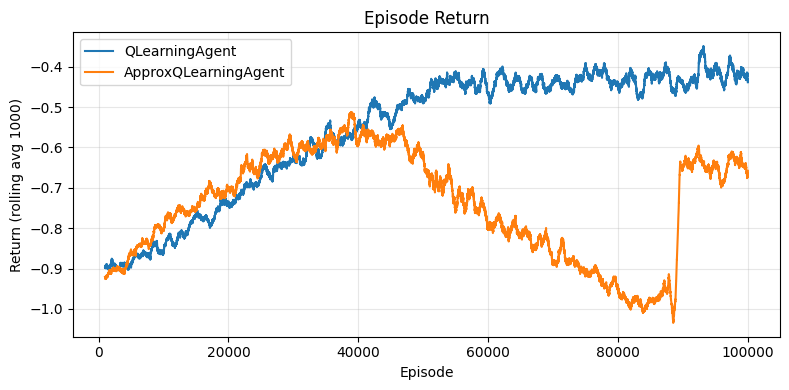

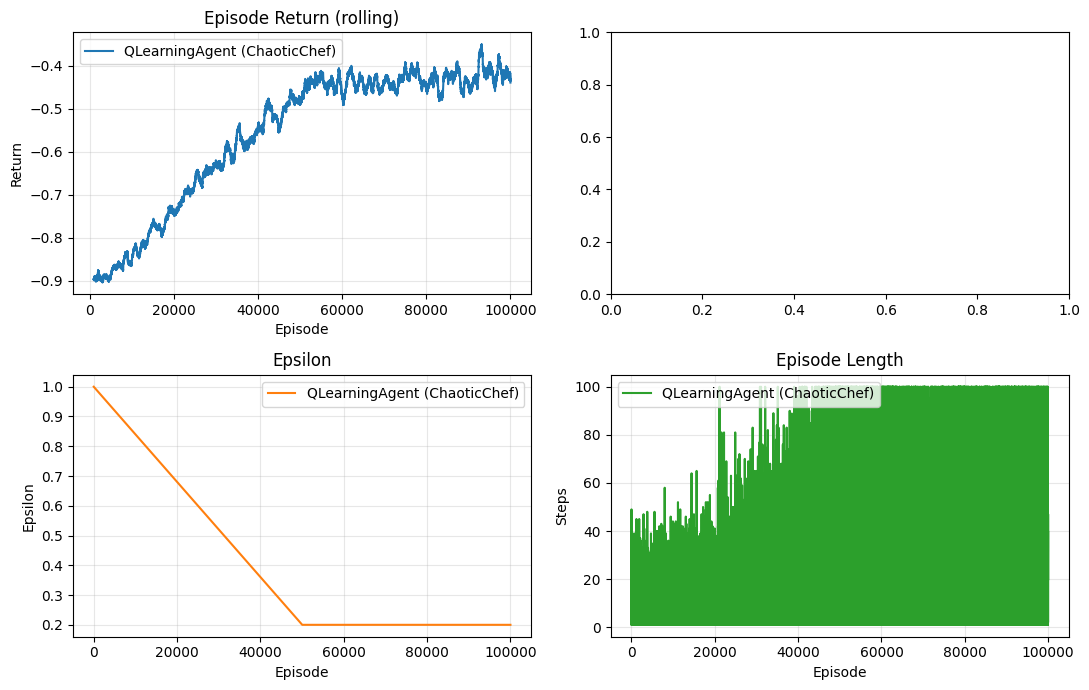

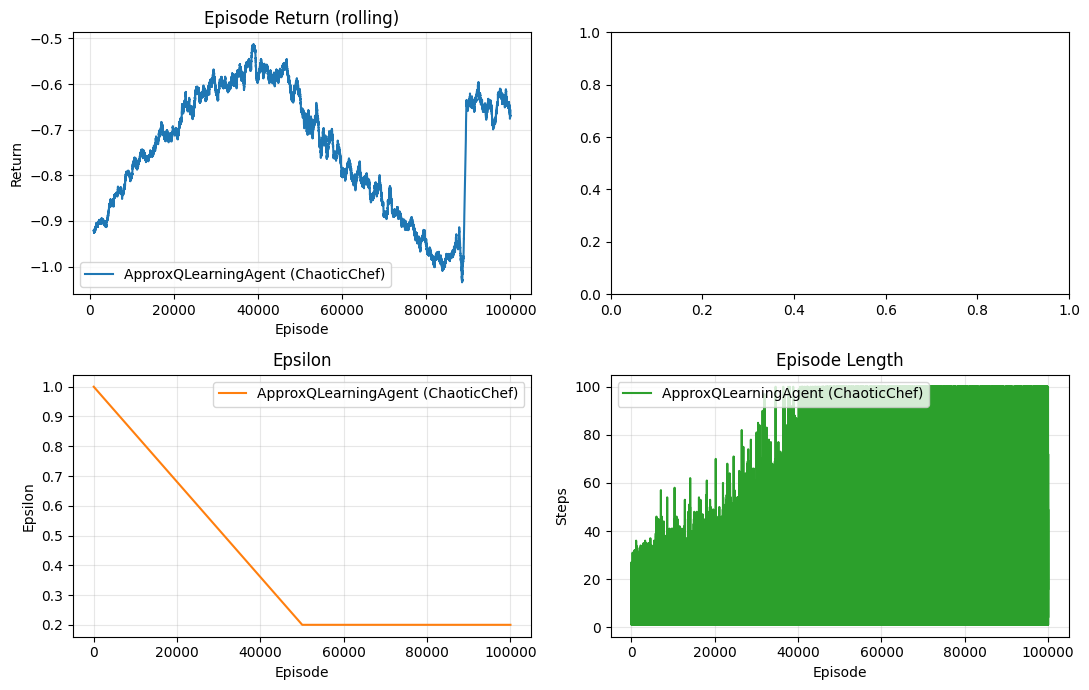

In [9]:
# Plot Learning Curves for ChaoticChef Agents

metrics.plot_returns([ql_agent_chaotic.logs["episode_rewards"], approx_ql_agent_chaotic.logs["episode_rewards"]],
                     ["QLearningAgent", "ApproxQLearningAgent"],
                     window=1000)

# Plot Epsilon Schedules and Episode Lengths for QLearningAgent on ChaoticChef
metrics.plot_agent_logs(ql_agent_chaotic.logs, label="QLearningAgent (ChaoticChef)")

# Plot Epsilon Schedules and Episode Lengths for ApproxQLearningAgent on ChaoticChef
metrics.plot_agent_logs(approx_ql_agent_chaotic.logs, label="ApproxQLearningAgent (ChaoticChef)")

#### **ChaoticChef environment performance**


The QLearningAgent demonstrated a more stable performance: during the exploration phase (0-50k episodes) there is improvement that gradually becomes consistent in the exploitation phase (**~-0.40**)

The ApproxQLearningAgent showed an unstable Learning; after the initial learning on the first 40k episodes (going **from -0.9 to -0.50**), given the **lower learning rate 5e-4** and **ε > 0.2**,  there is a gradual performance degradation around 40k to 85k episodes, going **from -0.50 to -1.00**. Then for the last 15k episodes there is a sudden improvement **from -1.00 to -0.60**, but with high variance in performance



Despite both agents consistently hit the max_steps=100 limit throughout training, the agents achieve different returns:

**QLearningAgent: 100 steps,  -0.42 average return**

**ApproxQLearningAgent: 100 steps, -0.65 to -1.0 average return**

This means they tend to make different decisions:

QLearningAgent uses those 100 steps much **more effectively, accumulating less negative reward** through better action selection.

ApproxQLearningAgent takes actions that **accumulate more negative rewards**, such as visiting wrong locations, picking up wrong ingredients, failing to complete cooking or wasting time on low-reward actions.







## **The `BudgetChef` environment**

In this variant, the agent still plays as a chef navigating the 5×5 city grid of markets, but now a **monetary budget** is introduced. Each ingredient has a purchase cost, and each cooked dish generates revenue depending on its quality. The challenge is no longer just to maximize dish value, but to  **maximize the chef’s total wealth** after a sequence of episodes.

An episode ends when one of the following occurs:
- The agent chooses the **Cook** action  
- The maximum number of steps is reached  
- The budget is fully exhausted (no further actions possible)

**State Space**

The observation includes:
- `position`: the chef’s current coordinates `(row, col)` on the grid  
- `bag`: the inventory of collected ingredients (with counts)  
- `steps_left`: how many moves remain before the episode ends  
- `budget_ratio`: the remaining budget divided by the initial budget  




**Actions**

`0`: Move left  
`1`: Move down  
`2`: Move right  
`3`: Move up  
`4`: Cook (stop exploring and attempt to prepare a dish)  


**Rewards**

In addition to the recipe score defined in `_cook_and_score()`, BudgetChef modifies the reward function to incorporate **costs and revenues**:

When the agent chooses `cook`, the revenue is computed as:

$$
\text{Revenue} = \max(0, R_{\text{dish}} \times m)
$$

Where:  

- $R_{\text{dish}}$ = score from `_cook_and_score()`, determined by the ingredients collected and the recipe matched  
- $m$ = `revenue_multiplier` (scaling factor, default = 1.0)

The **budget after cooking** is updated as:

$$
\text{Budget}_{\text{after cook}} = \text{Budget}_{\text{before cook}} + \text{Revenue}
$$



**Transitions**

Transitions are deterministic given the chosen action:
- Movement actions update the `position` and, if applicable, add an ingredient to the bag while reducing the budget.  
- The `Cook` action ends the episode and computes the recipe reward plus revenue.  




In [10]:
# Parameters
grid_size = 5
max_steps = 100
episodes = 100000
start_budget = 30


# Epsilon parameters
initial_epsilon = 1.0
epsilon_min = 0.02
epsilon_decay = (1.0 - 0.02) / 50000

# Instantiate environment and agents
budget_env = gym.make("BudgetChef-v0", grid_size=grid_size, max_steps=max_steps, start_budget=start_budget, verbose=False)

ql_agent = agents.QLearningAgent(
    action_space_n=budget_env.action_space.n,
    epsilon=initial_epsilon,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay
)

approx_ql_agent = agents.ApproxQLearningAgent(
    action_space_n=budget_env.action_space.n,
    feature_dim=agents.featurize(budget_env.observation_space.sample()).size,
    epsilon=initial_epsilon,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay
)

# Train agents on BudgetChef
train_agent(ql_agent, budget_env, episodes, "QLearningAgent")
train_agent(approx_ql_agent, budget_env, episodes, "ApproxQLearningAgent")

  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 100000 | Epsilon = 0.020 | Steps = 16 | Reward = -0.76 | Truncated = False | Cooking Reward = -0.21


  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 100000 | Epsilon = 0.020 | Steps = 1 | Reward = -0.01 | Truncated = False | Cooking Reward = -0.01


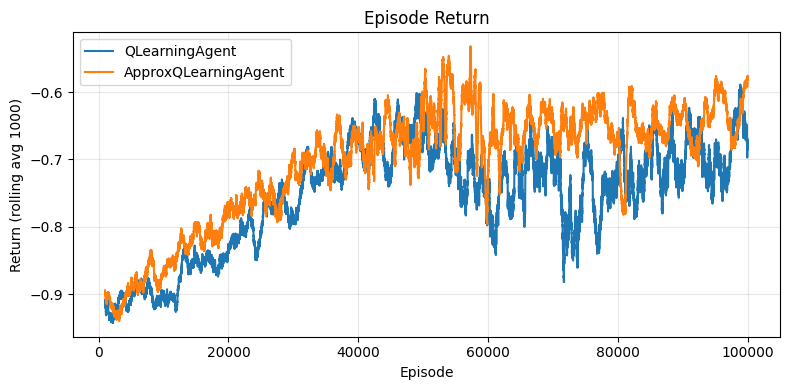

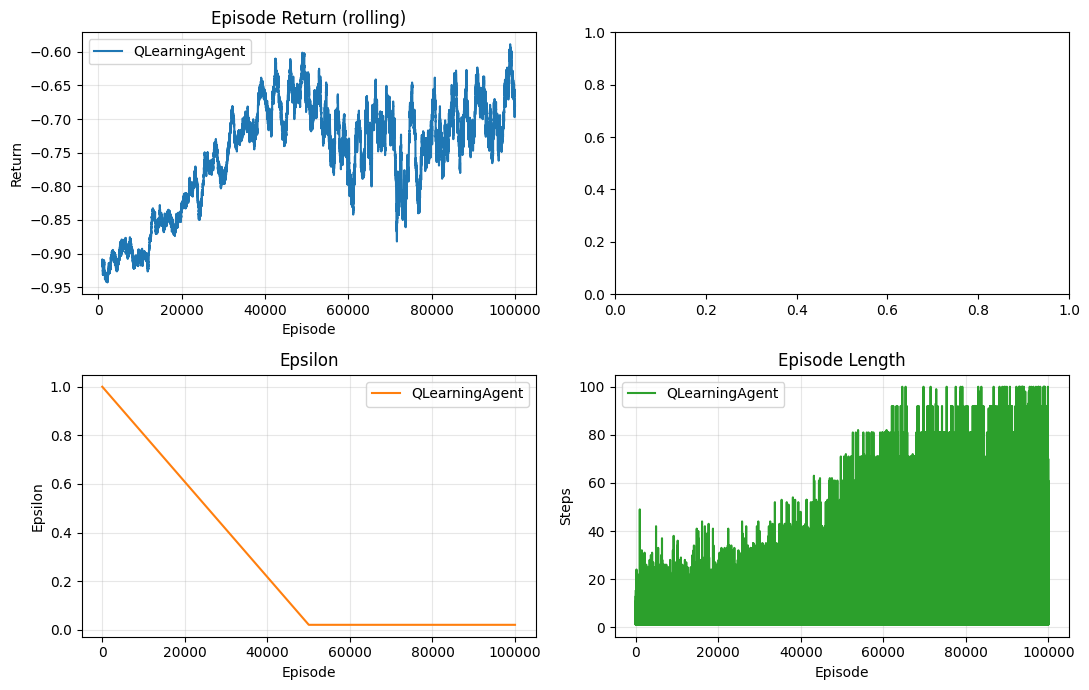

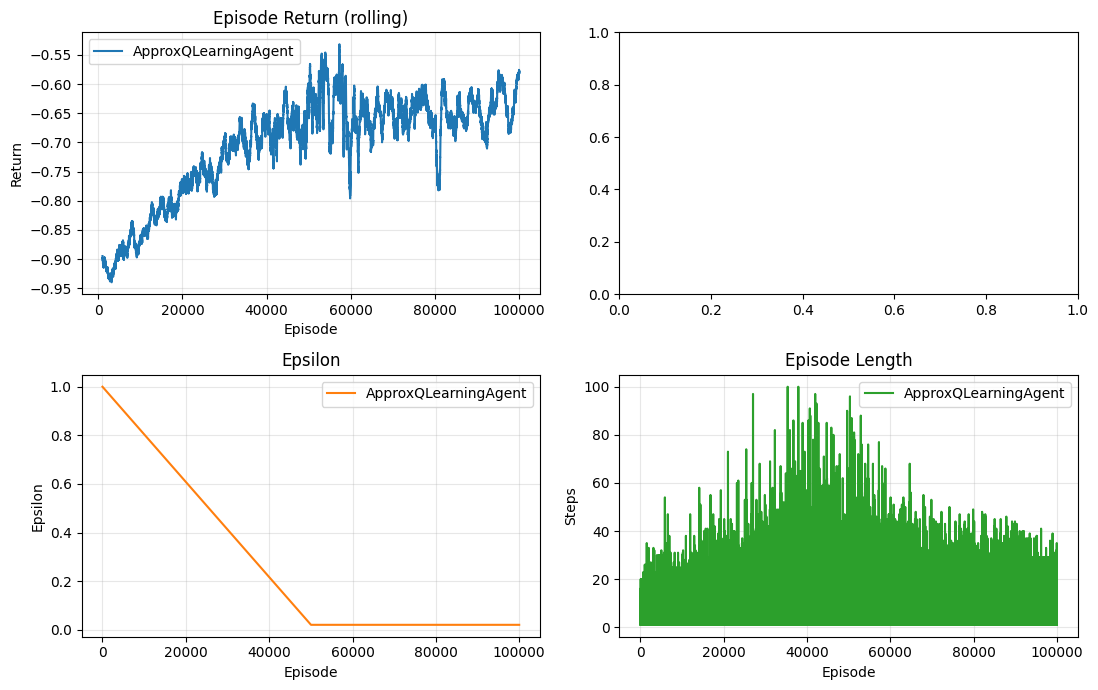

In [11]:
# Plot Learning Curves
metrics.plot_returns([ql_agent.logs["episode_rewards"], approx_ql_agent.logs["episode_rewards"]],
                     ["QLearningAgent", "ApproxQLearningAgent"],
                     window=1000)

# Plot Epsilon Schedules and Episode Lengths for QLearningAgent
metrics.plot_agent_logs(ql_agent.logs, label="QLearningAgent")

# Plot Epsilon Schedules and Episode Lengths for ApproxQLearningAgent
metrics.plot_agent_logs(approx_ql_agent.logs, label="ApproxQLearningAgent")

#### **Budget environment Performance**


##### **Episode Return**


Unlike ChaoticChef, both agents achieve very similar learning curves and final performance. And the **ApproxQLearningAgent** even slightly **outperforms the tabular agent.**
BudgetChef has significantly more states than ChaoticChef and neural network can learn patterns across similar budget values while tabular method must store each (grid_pos, budget) combination separately, also the budget decrease predictably


##### **Episode Length**


QLearningAgent learns to survive longer by managing budget better, in this environment **early termination indicates running out of budget or getting stuck**, so longer episodes shows more efficient resource usage, but longer episodes don't guarantee better returns: In later episodes (60k-100k), when length is highest, returns show more variance and occasional worse performance (-0.75 to -0.85)


ApproxQLearningAgent shows a highly volatile approach, experimenting with different approaches and learning to terminate early rather than optimal budget usage learned that this lead to **less opportunity to accumulate negative rewards**

##### **Environment comparison**


A comparison of the environemnt performances shows that **task structure matters:**

**ChaoticChef favored the tabular agent** because the environment was small, highly random, and lacked smooth structure. Direct tabular updates were stable and more effective than trying to generalize across unrelated states.

**BudgetChef favors Neural Networks** because the continuous budget dimension and structured task dynamics rewarded generalization. Neural networks could exploit smooth patterns, reducing the need to memorize a massive state space.




In [12]:
#ql_agent

print("Running a single verbose evaluation episode (ql_agent): ")
eval_env_verbose = gym.make("BudgetChef-v0", grid_size=5, max_steps=100, start_budget=30, verbose=True)

obs, info = eval_env_verbose.reset()
done = False
episode_reward = 0
steps = 0

# Using the trained QLearningAgent's greedy policy
agent_to_evaluate1 = ql_agent

while not done:
    action = agent_to_evaluate1.greedy_policy(obs)
    next_obs, reward, terminated, truncated, info = eval_env_verbose.step(action)

    episode_reward += reward
    steps += 1
    done = terminated or truncated
    obs = next_obs

print(f"Total Steps: {steps}")
print(f"Total Episode Reward: {episode_reward:.2f}")
print(f"Final Cooking Reward: {reward:.2f}") # Assuming the last reward is cooking reward

Running a single verbose evaluation episode (ql_agent): 

Current position: (np.int64(2), np.int64(2)) (Meat)
Current budget: 22.00
Action: pick (4)
Step: 1
Picked: Meat (cost: 8)
Reward: -0.01

Current position: (np.int64(2), np.int64(2)) (Meat)
Current budget: 14.00
Action: left (2)
Step: 2
Moved to: (np.int64(2), np.int64(1)) (Pepper)
Paid cost: 2, Remaining budget: 12.00
Reward: -0.01

Current position: (np.int64(2), np.int64(1)) (Pepper)
Current budget: 12.00
Action: pick (4)
Step: 3
Picked: Pepper (cost: 2)
Reward: -0.01

Current position: (np.int64(2), np.int64(1)) (Pepper)
Current budget: 10.00
Action: right (3)
Step: 4
Moved to: (np.int64(2), np.int64(2)) (Meat)
Paid cost: 8, Remaining budget: 2.00
Reward: -0.01

Current position: (np.int64(2), np.int64(2)) (Meat)
Current budget: 2.00
Action: cook (5)
Step: 5
Cooking. Ingredients: ['Meat', 'Pepper']
Best recipe matched: "Failed Dish", Reward: -0.20, Revenue: 0.00
New budget: 2.00
Reward: -0.21000000000000002
Total Steps: 5
Tot

In [13]:
#approx_ql_agent

print("Running a single verbose evaluation episode (approx_ql_agent): ")
eval_env_verbose = gym.make("BudgetChef-v0", grid_size=5, max_steps=100, start_budget=30, verbose=True)

obs, info = eval_env_verbose.reset()
done = False
episode_reward = 0
steps = 0

# Using the trained QLearningAgent's greedy policy
agent_to_evaluate2 = approx_ql_agent

while not done:
    action = agent_to_evaluate2.greedy_policy(obs)
    next_obs, reward, terminated, truncated, info = eval_env_verbose.step(action)

    episode_reward += reward
    steps += 1
    done = terminated or truncated
    obs = next_obs

print(f"Total Steps: {steps}")
print(f"Total Episode Reward: {episode_reward:.2f}")
print(f"Final Cooking Reward: {reward:.2f}") # last reward is cooking reward

Running a single verbose evaluation episode (approx_ql_agent): 

Current position: (np.int64(0), np.int64(4)) (Shrimp)
Current budget: 23.00
Action: left (2)
Step: 1
Moved to: (np.int64(0), np.int64(3)) (Tomato)
Paid cost: 2, Remaining budget: 21.00
Reward: -0.01

Current position: (np.int64(0), np.int64(3)) (Tomato)
Current budget: 21.00
Action: left (2)
Step: 2
Moved to: (np.int64(0), np.int64(2)) (Mushroom)
Paid cost: 4, Remaining budget: 17.00
Reward: -0.01

Current position: (np.int64(0), np.int64(2)) (Mushroom)
Current budget: 17.00
Action: left (2)
Step: 3
Moved to: (np.int64(0), np.int64(1)) (Cheese)
Paid cost: 5, Remaining budget: 12.00
Reward: -0.01

Current position: (np.int64(0), np.int64(1)) (Cheese)
Current budget: 12.00
Action: pick (4)
Step: 4
Picked: Cheese (cost: 5)
Reward: -0.01

Current position: (np.int64(0), np.int64(1)) (Cheese)
Current budget: 7.00
Action: left (2)
Step: 5
Moved to: (np.int64(0), 0) (Tomato)
Paid cost: 2, Remaining budget: 5.00
Reward: -0.01

Cu

In [16]:
# Evaluate the trained agents' greedy policies

episodes = 100000

print("Evaluating Greedy Policies on BudgetChef env:")

# Evaluate QLearningAgent
ql_final_cooking_rewards = []
ql_episode_rewards = []

for _ in range(episodes):
    obs, _ = budget_env.reset()
    done = False
    episode_reward = 0
    while not done:
        action = ql_agent.greedy_policy(obs)
        next_obs, reward, terminated, truncated, info = budget_env.step(action)
        episode_reward += reward
        done = terminated or truncated
        obs = next_obs
    ql_final_cooking_rewards.append(reward) # Final reward is the cooking reward
    ql_episode_rewards.append(episode_reward)

avg_ql_cooking_reward = np.mean(ql_final_cooking_rewards)
avg_ql_episode_reward = np.mean(ql_episode_rewards)

print(f"\nQLearningAgent (BudgetChef):")
print(f"  Average Final Cooking Reward: {avg_ql_cooking_reward:.2f}")
print(f"  Average Total Episode Reward: {avg_ql_episode_reward:.2f}")

# Evaluate ApproxQLearningAgent
approx_ql_final_cooking_rewards = []
approx_ql_episode_rewards = []

for _ in range(episodes):
    obs, _ = budget_env.reset()
    done = False
    episode_reward = 0
    while not done:
        action = approx_ql_agent.greedy_policy(obs)
        next_obs, reward, terminated, truncated, info = budget_env.step(action)
        episode_reward += reward
        done = terminated or truncated
        obs = next_obs
    approx_ql_final_cooking_rewards.append(reward) # Final reward is the cooking reward
    approx_ql_episode_rewards.append(episode_reward)

avg_approx_ql_cooking_reward = np.mean(approx_ql_final_cooking_rewards)
avg_approx_ql_episode_reward = np.mean(approx_ql_episode_rewards)

print(f"\nApproxQLearningAgent (BudgetChef):")
print(f"  Average Final Cooking Reward: {avg_approx_ql_cooking_reward:.2f}")
print(f"  Average Total Episode Reward: {avg_approx_ql_episode_reward:.2f}")

Evaluating Greedy Policies on BudgetChef env:

QLearningAgent (BudgetChef):
  Average Final Cooking Reward: -0.16
  Average Total Episode Reward: -1.52

ApproxQLearningAgent (BudgetChef):
  Average Final Cooking Reward: -0.46
  Average Total Episode Reward: -0.66


**Analysis of Greedy Policy Evaluation Results**

The greedy policy evaluation tests the agent’s learned policy without exploration (on the `BudgetChef` environment). The greedy policy always selects the action with the highest estimated Q-value for the current state, without any exploration.

The `greedy_policy` method for the QLearningAgent selects the action with the highest Q-value for the current state. If the state is unseen, it picks a random action.

In the ApproxQLearningAgent it uses the neural network to compute Q-values for the current state and selects the action with the highest Q-value (using `q.argmax(dim=1).item()`).


**Comparison and Interpretation:**

Both agents have **negative rewards**, indicating suboptimal policies howerver,  
the tabular QLearningAgent achieves a higher final cooking reward but a lower total episode reward compared to the ApproxQLearningAgent.
The ApproxQLearningAgent, while having a worse final cooking reward, accumulates a better total episode reward over the episode.


The tabular agent may be better at optimizing for the final state due to its **ability to memorize specific state-action pairs**, but struggles with overall episode management, due to **limited generalization**.

The approximate agent generalizes across states, which can help it **accumulate rewards more consistently** throughout the episode, but may not learn the optimal actions for the final cooking step as precisely.


In [17]:
# Print Evaluation Results
avg_cooking_rewards = [np.mean(ql_final_cooking_rewards), np.mean(approx_ql_final_cooking_rewards)]
std_cooking_rewards = [np.std(ql_final_cooking_rewards), np.std(approx_ql_final_cooking_rewards)]

avg_episode_rewards = [np.mean(ql_episode_rewards), np.mean(approx_ql_episode_rewards)]
std_episode_rewards = [np.std(ql_episode_rewards), np.std(approx_ql_episode_rewards)] # Corrected variable name


print("\nEvaluation Results:")
print(f"{'Metric':<30} | {'QLearningAgent':<20} | {'ApproxQLearningAgent':<25}")
print("-" * 90)
print(f"{'Average Final Cooking Reward':<30} | {np.mean(ql_final_cooking_rewards):<20.2f} | {np.mean(approx_ql_final_cooking_rewards):<25.2f}")
print(f"{'Std Dev Final Cooking Reward':<30} | {np.std(ql_final_cooking_rewards):<20.2f} | {np.std(approx_ql_final_cooking_rewards):<25.2f}")
print(f"{'Average Total Episode Reward':<30} | {np.mean(ql_episode_rewards):<20.2f} | {np.mean(approx_ql_episode_rewards):<25.2f}")
print(f"{'Std Dev Total Episode Reward':<30} | {np.std(ql_episode_rewards):<20.2f} | {np.std(approx_ql_episode_rewards):<25.2f}")


Evaluation Results:
Metric                         | QLearningAgent       | ApproxQLearningAgent     
------------------------------------------------------------------------------------------
Average Final Cooking Reward   | -0.16                | -0.46                    
Std Dev Final Cooking Reward   | 0.33                 | 0.46                     
Average Total Episode Reward   | -1.52                | -0.66                    
Std Dev Total Episode Reward   | 2.27                 | 0.78                     


#### **Conclusion**

While theory suggests that neural networks should outperform through sample efficiency and generalization, results reveal a different reality.

ChaoticChef has a relatively small state space that the **tabular agent** can cover in a compact and stochastic environment, therefore memorizing values directly works better than attempting to generalize.

BudgetChef, however, introduces a continuous budget dimension that increases the effective size of the state space. More importantly, budget values are naturally smooth. `ApproxQLearningAgent` thrives in this setting, as it can interpolate between states and transfer learning from one budget range to another.

I designed the Chaotic environment with a penalty-heavy reward structure. The intention was to punish mistakes strongly so that the agent avoids random collecting. In this case, scores become highly sensitive to small differences, just one extra wrong ingredient can lower the outcome. And the agent may learn to focus more on avoiding failure than on actively seeking successful strategies which is the case of the ApproxQLearningAgent that learned to terminate early rather than optimal budget usage **to avoid accumulating negative rewards**.
While QLearningAgent learned to survive longer by **managing budget better**.
